In [52]:
# Import librarys
# normal 
import matplotlib.pyplot as plt
import cv2
import imutils
import numpy as np
import pandas as pd

# open file
from IPython.display import Image
from sklearn.datasets import load_files
import os
import PIL

# model CNN (Deep learning network)
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,\
GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# model Transfer Learning
from keras.models import Model
from keras.applications import MobileNetV2

# Weight and Bias
import wandb
from wandb.integration.keras import WandbModelCheckpoint, WandbMetricsLogger



# Open Datasets

In [4]:
# Open path file of dataset 
dataset_path = "dataset-augmented"

train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")
test_dir = os.path.join(dataset_path, "test")

In [41]:
ds = 'dataset-augmented/train'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_train, y_train,target_labels = load_dataset(ds)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])

Loading complete!
Training set size :  2675


In [44]:
folder = 'dataset-augmented'
main_folders = ['train', 'valid', 'test']

# Iterasi pada folder utama
for main_folder in main_folders:
    folder_path = os.path.join(folder, main_folder)
    if os.path.isdir(folder_path):
        print(f"\nIn folder '{main_folder}':")
        # Daftar tipe sampah (subfolder)
        garbage_types = os.listdir(folder_path)
        for garbage_type in garbage_types:
            subfolder_path = os.path.join(folder_path, garbage_type)
            if os.path.isdir(subfolder_path):
                # Filter file gambar (jpg, jpeg)
                image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('jpg', 'jpeg'))]
                # Hitung jumlah gambar
                num_images = len(image_files)
                print(f"  {garbage_type} folder contains {num_images} images.")


In folder 'train':
  cardboard folder contains 440 images.
  glass folder contains 440 images.
  metal folder contains 440 images.
  paper folder contains 475 images.
  plastic folder contains 440 images.
  trash folder contains 440 images.

In folder 'valid':
  cardboard folder contains 55 images.
  glass folder contains 55 images.
  metal folder contains 55 images.
  paper folder contains 59 images.
  plastic folder contains 55 images.
  trash folder contains 55 images.

In folder 'test':
  cardboard folder contains 55 images.
  glass folder contains 55 images.
  metal folder contains 55 images.
  paper folder contains 60 images.
  plastic folder contains 55 images.
  trash folder contains 55 images.


# Augmentation Image Dataset

In [5]:
# Set parameter of image 
# We use input small size image because reduce size of model 
batch_size = 50  # Set the batch size for epoch cycle
img_height = 224 # Set the height of the picture
img_width = 224  # Set the width of the picture

# Rescale pixel to reduce image size before using in model
data_gen_train = ImageDataGenerator(rescale=1./255,
                                    fill_mode='nearest',
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    zoom_range=0.2,
                                    shear_range=0.2,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2)

data_gen_valid = ImageDataGenerator(rescale=1./255)
data_gen_test = ImageDataGenerator(rescale=1./255)

In [6]:
# Create training dataset 
train_dataset = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=True)
 

# Create validation dataset 
valid_dataset = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=False)

# Create testing dataset 
test_dataset = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=False)

Found 2675 images belonging to 6 classes.
Found 334 images belonging to 6 classes.
Found 335 images belonging to 6 classes.


In [7]:
train_dataset.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

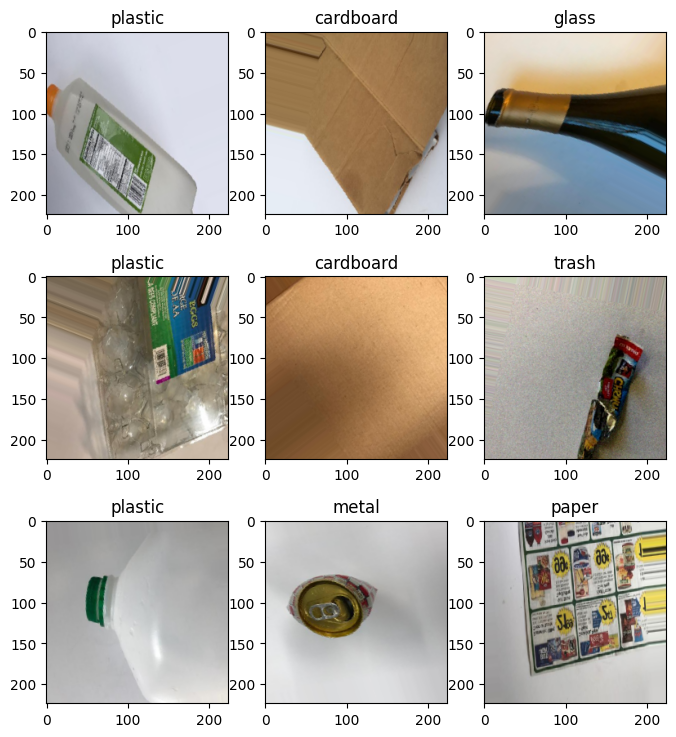

In [10]:
# show some image sample in training dataset
images, labels_class = next(train_dataset)
classes = train_dataset.class_indices
plt.figure(figsize=(8, 9))
for i in range(9):
    label = [j for j in classes if classes[j] == np.argmax(labels_class[i])][0]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i]*255.).astype("uint8"))
    plt.title(label)

# CNN Model Training

In [12]:
# Training model
# Compile the model
cnn_model = Sequential()

# Input layer
cnn_model.add(Conv2D(16,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same', input_shape=(224,224,3))) 
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

# Hidden layers 1
cnn_model.add(Conv2D(32,(3,3), activation='relu',
                 padding='same'))
cnn_model.add(BatchNormalization()) 
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layers 2
cnn_model.add(Conv2D(32,(3,3), activation='relu',
                 padding='same'))
cnn_model.add(BatchNormalization()) 
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layers 3
cnn_model.add(Conv2D(64,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same'))
cnn_model.add(BatchNormalization()) 
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layers 4
cnn_model.add(Conv2D(128,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same'))
cnn_model.add(BatchNormalization()) 
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden layers 5
cnn_model.add(Conv2D(256,(3,3), activation='relu',
                 kernel_initializer='he_uniform', 
                 padding='same'))
cnn_model.add(BatchNormalization()) 
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu',
                kernel_initializer='he_uniform'))

# Output layer
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(6, activation='softmax'))


Compiled!


# Compile Model

In [ ]:
# Compile the model         
cnn_model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
print('Compiled!')

In [13]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 224, 224, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 batch_normalization_7 (Bat  (None, 112, 112, 32)      128       
 chNormalization)                                                
                                                      

#  Model tracking using wandb.ai

In [14]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmzakif (ahmzakif-gadjah-mada-university). Use `wandb login --relogin` to force relogin


True

In [17]:
wandb.init(
    project="TrashNet - Classification",  
    config={
        "architecture": "CNN",
        "learning_rate":0.001,
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "batch_size": batch_size,
        "epochs": 100,
    }
)

# Callbacks

In [18]:

# Callback WandB
metrics_logger = WandbMetricsLogger()
wandb_checkpoint = WandbModelCheckpoint(
    filepath='model/cnn_model.keras',
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss'
)


# Callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor Validation Loss Metric
    factor=0.5,               # Reduce learning rate around 50%
    patience=5,               # Reduce Learning Rate if didn't improvement while 5 epoch
    verbose=1,                # Showing Log
    min_lr=1e-6               # Learning rate minimum
)

# Callback ModelCHeckpoint
checkpointer = ModelCheckpoint(
    filepath = 'model/cnn_model.keras',
    verbose = 1,
    save_best_only = True)

# Callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',            # Monitor Validation Loss Metric
    patience=10,                   # Wait 10 Epoch
    restore_best_weights=True,     # Return to best weight
    verbose=1                      # Show Log
)

callbacks = [
    checkpointer,
    reduce_lr,
    early_stopping,
    metrics_logger,
    wandb_checkpoint
]

# Train Model

In [19]:
cnn_history = cnn_model.fit(train_dataset,
        verbose=2, 
        epochs=100,
        callbacks = callbacks,
        batch_size = batch_size,
        validation_data=(valid_dataset),
        shuffle=True)

Epoch 1/100



Epoch 1: val_loss improved from inf to 2.00779, saving model to cnn_model.keras
54/54 - 32s - loss: 1.8341 - accuracy: 0.3402 - val_loss: 2.0078 - val_accuracy: 0.1886 - lr: 0.0010 - 32s/epoch - 589ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 2.00779
54/54 - 30s - loss: 1.4405 - accuracy: 0.4325 - val_loss: 2.2906 - val_accuracy: 0.1407 - lr: 0.0010 - 30s/epoch - 562ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 2.00779
54/54 - 28s - loss: 1.3723 - accuracy: 0.4665 - val_loss: 3.3786 - val_accuracy: 0.1677 - lr: 0.0010 - 28s/epoch - 528ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 2.00779
54/54 - 30s - loss: 1.3390 - accuracy: 0.4994 - val_loss: 2.7262 - val_accuracy: 0.1886 - lr: 0.0010 - 30s/epoch - 551ms/step
Epoch 5/100

Epoch 5: val_loss improved from 2.00779 to 1.75263, saving model to cnn_model.keras
54/54 - 29s - loss: 1.2619 - accuracy: 0.5084 - val_loss: 1.7526 - val_accuracy: 0.3503 - lr: 0.0010 - 29s/epoch - 532ms/ste

# Plot Graph

In [3]:
# Create function plot loss function and accuracy score graph
def plot_graph(model_values):
    ''' 
    Input : Model_values of keras.callbacks.History
    Return : Graph of Loss function and accuracy score between training dataset and vaildation dataset
    '''
    # Subplots
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(model_values.history['loss'], label='Training Loss');
    plt.plot(model_values.history['val_loss'], label='Testing Loss');
    plt.legend(fontsize=12, loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss');
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    
    plt.plot(model_values.history['accuracy'], label='Training Accuracy')
    plt.plot(model_values.history['val_accuracy'], label='Validation Accuracy')
    
    plt.legend(fontsize=12, loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

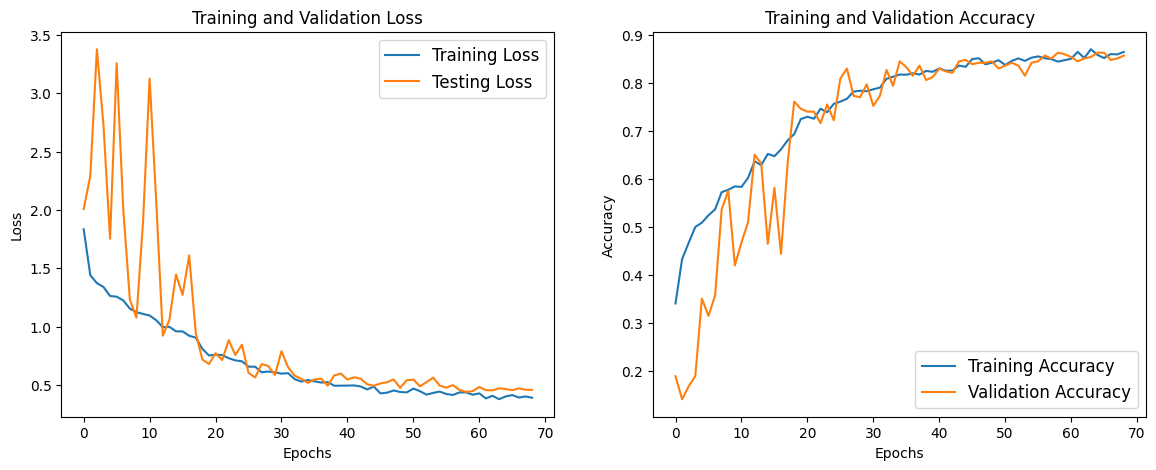

In [20]:
# plot graph 
plot_graph(cnn_history)

# Evaluate Model

In [23]:
def evaluate_model_performance(model, val_generator, class_labels):
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [24]:
class_labels = list(valid_dataset.class_indices.keys())

7/7 [==============================] - 1s 125ms/step
              precision    recall  f1-score   support

   cardboard       0.90      0.96      0.93        55
       glass       0.86      0.78      0.82        55
       metal       0.88      0.84      0.86        55
       paper       0.88      0.86      0.87        59
     plastic       0.79      0.80      0.79        55
       trash       0.86      0.93      0.89        55

    accuracy                           0.86       334
   macro avg       0.86      0.86      0.86       334
weighted avg       0.86      0.86      0.86       334





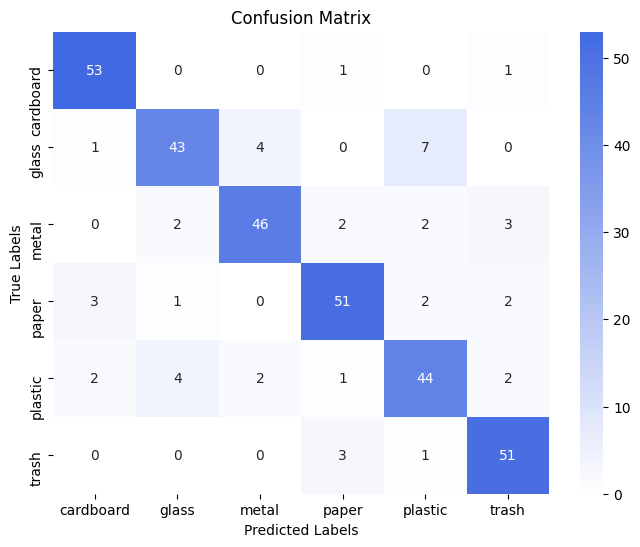

In [25]:
evaluate_model_performance(cnn_model, valid_dataset, class_labels)


# Inference Model

2/2 [==============================] - 0s 11ms/step


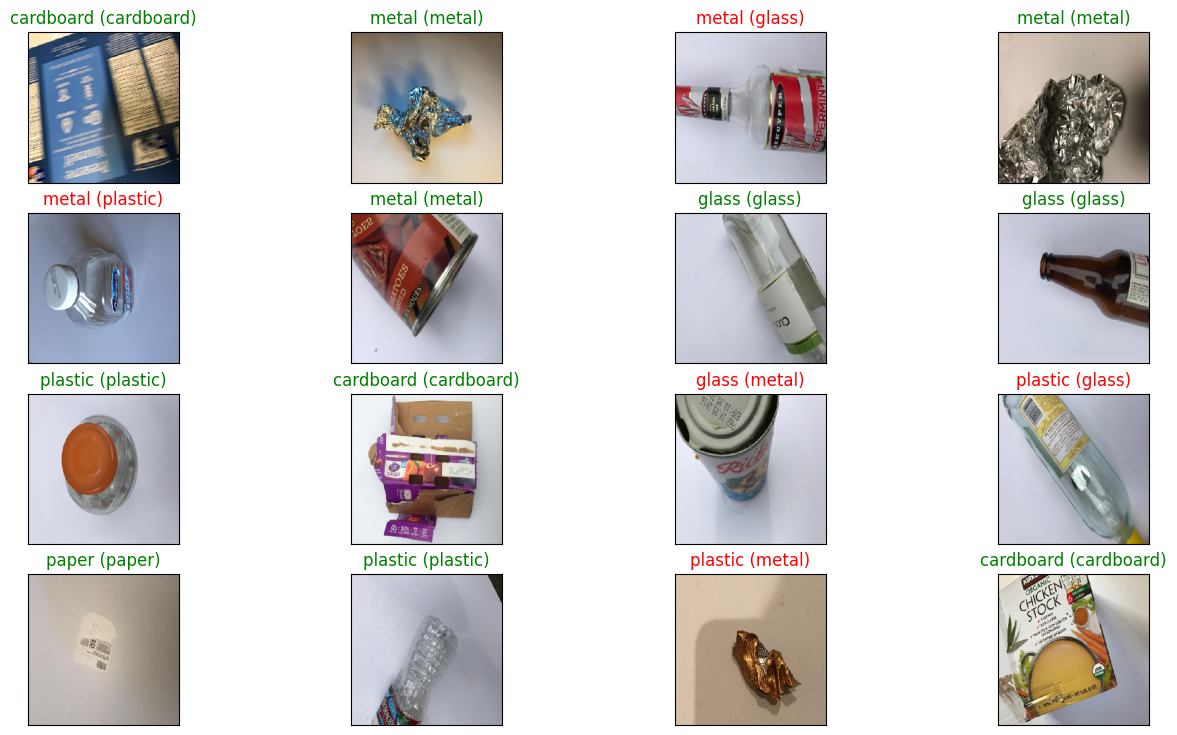

In [45]:
# Iterasi untuk semua batch di validation_generator
all_images = []
all_labels = []
all_preds = []
labels = train_dataset.class_indices

for images, labels in valid_dataset:
    # Prediksi untuk batch saat ini
    preds = cnn_model.predict(images)
    all_images.extend(images)
    all_labels.extend(labels)
    all_preds.extend(preds)

    # Berhenti jika semua data sudah diproses
    if len(all_images) >= valid_dataset.n:
        break

# Konversi hasil ke array numpy
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Visualisasi
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(len(all_images), size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(all_images[idx])
    pred_idx = np.argmax(all_preds[idx])
    true_idx = np.argmax(all_labels[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

# Transfer Learning

## Make Pretrained Model MobileNetV2

In [47]:
# Load the MobileNetV2 model with weights pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [48]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

# Freeze Layers

In [50]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name)


0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [51]:
# Freeze early layers
for layer in base_model.layers[:100]:  # Freeze layers 0-99
    layer.trainable = False
    
# Unfreeze middle and top layers
for layer in base_model.layers[100:]:  # Layers 100-153
    layer.trainable = True

# Build Model

In [53]:
mobnet_model = base_model.output
mobnet_model = GlobalAveragePooling2D()(mobnet_model)
mobnet_model = Dropout(0.5)(mobnet_model)
mobnet_model = Dense(6, activation='softmax')(mobnet_model)

transfer_mobnet_model = Model(inputs=base_model.input, outputs=mobnet_model)

# Compile Model

In [55]:
# Compile Model
transfer_mobnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower Learning Rate for Greate Transfer Learning
    loss='categorical_crossentropy',      # Clasification Multiclass
    metrics=['accuracy']                  # use Accuracy for Metrics
)


In [54]:
transfer_mobnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

# Checkpoint

In [67]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [72]:
wandb.init(
    project="TrashNet - Classification",  
    config={
        "architecture": "MobileNetV2",
        "name": "MobileNetV2",
        "learning_rate":0.001,
        "optimizer": "Adam",
        "loss_function": "categorical_crossentropy",
        "metrics": ["accuracy"],
        "batch_size": batch_size,
        "epochs": 100,
    }
)

In [78]:

# Callback WandB
metrics_logger_mn = WandbMetricsLogger()
wandb_checkpoint_mn = WandbModelCheckpoint(
    filepath='model/mobnet_model.keras',
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy'
)


# Callback ReduceLROnPlateau
reduce_lr_mn = ReduceLROnPlateau(
    monitor='val_accuracy',       # Monitor Validation Loss Metric
    factor=0.5,               # Reduce learning rate around 50%
    patience=5,               # Reduce Learning Rate if didn't improvement while 5 epoch
    verbose=1,                # Showing Log
    min_lr=1e-6               # Learning rate minimum
)

# Callback ModelCHeckpoint
checkpointer_mn = ModelCheckpoint(
    filepath = 'model/mobnet_model.keras',
    verbose = 1,
    save_best_only = True)

# Callback EarlyStopping
early_stopping_mn = EarlyStopping(
    monitor='val_accuracy',            # Monitor Validation Loss Metric
    patience=10,                   # Wait 10 Epoch
    restore_best_weights=True,     # Return to best weight
    verbose=1                      # Show Log
)

callbacks_mn = [
    checkpointer_mn,
    reduce_lr_mn,
    early_stopping_mn,
    metrics_logger_mn,
    wandb_checkpoint_mn
]

# Augmentation Image Dataset

In [79]:
# Rescale pixel to reduce image size before using in model
data_gen_train_mn = ImageDataGenerator(rescale=1./255,
                                    fill_mode='nearest',
                                    vertical_flip=True,
                                    horizontal_flip=True,
                                    zoom_range=0.3,
                                    shear_range=0.3,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3)

data_gen_valid_mn = ImageDataGenerator(rescale=1./255)
data_gen_test_mn = ImageDataGenerator(rescale=1./255)

In [80]:
# Create training dataset 
train_dataset_mn = data_gen_train.flow_from_directory(train_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=True)
 

# Create validation dataset 
valid_dataset_mn = data_gen_valid.flow_from_directory(valid_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=False)

# Create testing dataset 
test_dataset_mn = data_gen_test.flow_from_directory(test_dir,
                                                   class_mode="categorical",
                                                   target_size=(img_height, img_width),
                                                   batch_size=batch_size,
                                                   shuffle=False)

Found 2675 images belonging to 6 classes.
Found 334 images belonging to 6 classes.
Found 335 images belonging to 6 classes.


# Train MobileNetV2

In [81]:
mobnet_history = transfer_mobnet_model.fit(train_dataset_mn,
        verbose=2, 
        epochs=100,
        callbacks = callbacks_mn,
        batch_size = batch_size,
        validation_data=(valid_dataset_mn),
        shuffle=True)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.91630, saving model to model\mobnet_model.keras
54/54 - 36s - loss: 0.7432 - accuracy: 0.7320 - val_loss: 1.9163 - val_accuracy: 0.4072 - lr: 2.5000e-05 - 36s/epoch - 675ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.91630
54/54 - 37s - loss: 0.6552 - accuracy: 0.7637 - val_loss: 1.9453 - val_accuracy: 0.4042 - lr: 2.5000e-05 - 37s/epoch - 681ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.91630 to 1.83108, saving model to model\mobnet_model.keras
54/54 - 36s - loss: 0.5739 - accuracy: 0.7944 - val_loss: 1.8311 - val_accuracy: 0.4251 - lr: 2.5000e-05 - 36s/epoch - 661ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.83108 to 1.79897, saving model to model\mobnet_model.keras
54/54 - 35s - loss: 0.5543 - accuracy: 0.7989 - val_loss: 1.7990 - val_accuracy: 0.4311 - lr: 2.5000e-05 - 35s/epoch - 649ms/step
Epoch 5/100

Epoch 5: val_loss improved from 1.79897 to 1.63490, saving model to model\mobnet_model.keras


# Plot Graph

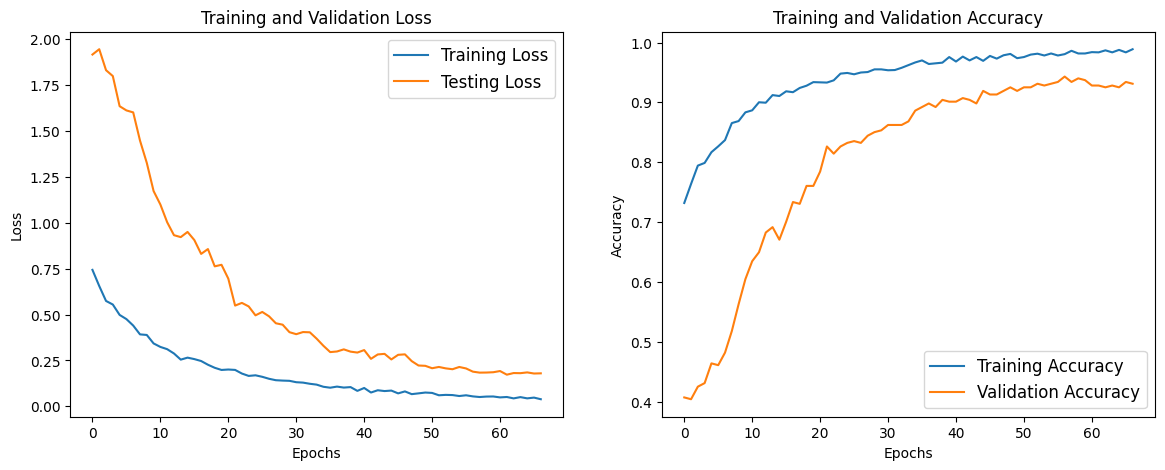

In [82]:
# plot graph 
plot_graph(mobnet_history)

# Evaluate Model

In [83]:
def evaluate_model_performance(model, val_generator, class_labels):
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [84]:
class_labels = list(valid_dataset_mn.class_indices.keys())

7/7 [==============================] - 2s 253ms/step
              precision    recall  f1-score   support

   cardboard       1.00      0.84      0.91        55
       glass       0.98      0.89      0.93        55
       metal       0.92      0.98      0.95        55
       paper       0.93      0.97      0.95        59
     plastic       0.95      0.98      0.96        55
       trash       0.90      1.00      0.95        55

    accuracy                           0.94       334
   macro avg       0.95      0.94      0.94       334
weighted avg       0.95      0.94      0.94       334





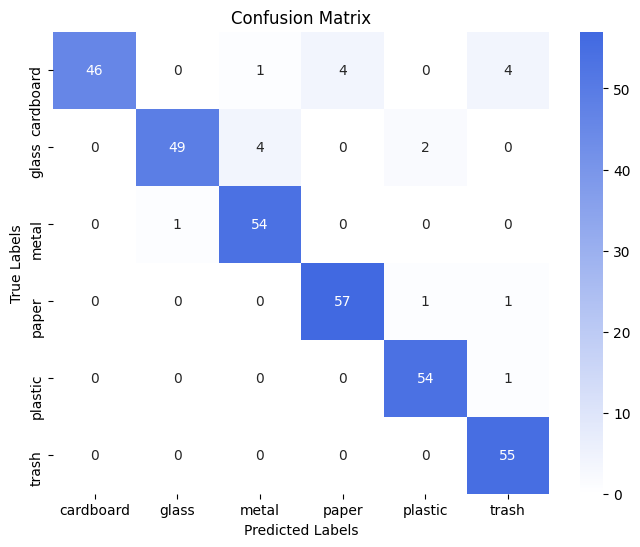

In [85]:
evaluate_model_performance(transfer_mobnet_model, valid_dataset_mn, class_labels)

# Inference Model

2/2 [==============================] - 0s 52ms/step


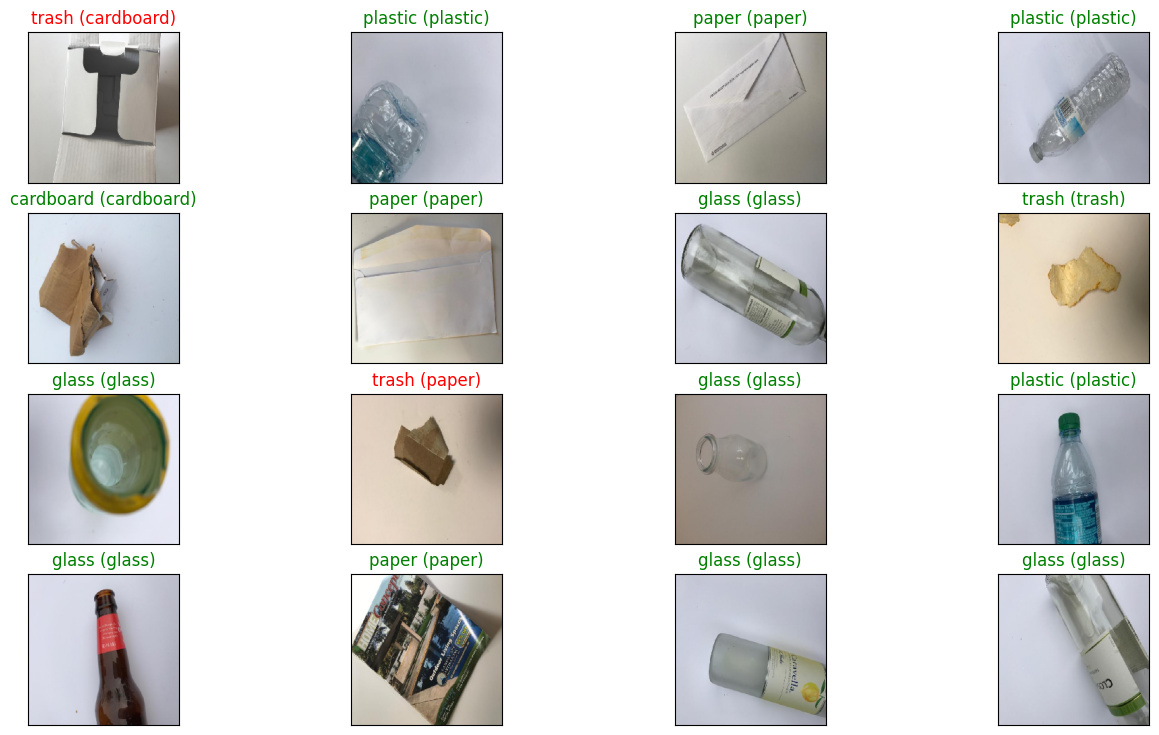

In [86]:
# Iterasi untuk semua batch di validation_generator
all_images = []
all_labels = []
all_preds = []
labels = train_dataset_mn.class_indices

for images, labels in valid_dataset_mn:
    # Prediksi untuk batch saat ini
    preds = transfer_mobnet_model.predict(images)
    all_images.extend(images)
    all_labels.extend(labels)
    all_preds.extend(preds)

    # Berhenti jika semua data sudah diproses
    if len(all_images) >= valid_dataset_mn.n:
        break

# Konversi hasil ke array numpy
all_images = np.array(all_images)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Visualisasi
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(len(all_images), size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(all_images[idx])
    pred_idx = np.argmax(all_preds[idx])
    true_idx = np.argmax(all_labels[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [87]:
wandb.finish()

epoch/accuracy,▁▁▂▂▄▄▅▅▅▆▆▆▆▆▆▅▆▄▅▅▆▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▂▂▂▂▃▄▄▄▄▅▅▆▆▇▇▇▇██▁▁▂▁▁▂▂▂▂▃▄▄▄▅▅▅▆▆▇█
epoch/learning_rate,█████▄▄▄▃▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/lr,██████▄▄▃▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▅▆▆▆▇▇▇▇▇███████████
epoch/val_loss,▅█▃█▅▄▃▄▂▂▂▂▂▂▂▂▂▂▂▂▆▆▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,0.98879
epoch/epoch,66
epoch/learning_rate,1e-05
epoch/loss,0.03845
